In [1]:
!nvidia-smi


Mon Feb 10 08:07:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
"""
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow==5.4.1'
!pip3 install 'tqdm'
!pip3 install python-utils
"""

"\n!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.4.2'\n!pip3 install 'Pillow==5.4.1'\n!pip3 install 'tqdm'\n!pip3 install python-utils\n"

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16_bn
#from torchvision.models import resnet101

from PIL import Image
from tqdm import tqdm

from torchvision.datasets import VisionDataset
import os.path
import sys
from __future__ import print_function


import numpy
import pylab as pl

from torch.autograd import Variable
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import copy

**Set Arguments**

In [0]:

DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 14 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 40     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 7      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10


**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
transforms_list=[]
transforms_list.append(torchvision.transforms.RandomPerspective())
transforms_list.append(transforms.RandomHorizontalFlip())
transforms_list.append(transforms.RandomRotation(degrees=[-180,180]))
transforms_list.append(transforms.RandomVerticalFlip())


train_transform = transforms.Compose([#transforms.Resize(256),
                                      #transforms.CenterCrop(224),
                                      #transforms.RandomCrop(448),
                                      transforms.Resize(224),
                                      transforms.RandomApply(transforms_list, p=0.6),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.Resize(256),
                                      #transforms.CenterCrop(224),
                                      #transforms.RandomCrop(448),
                                      #transforms.RandomApply(transforms_list,p=0.7),       
                                      transforms.Resize(224),                              
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])





**Prepare data for Pictures Dataset**

In [6]:
#mount drive for Dataset
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#DATA_DIR = '/content/drive/My Drive/Database_Definitivo_Resize224/'

DATA_DIR_Train = '/content/drive/My Drive/Database_896x896_14Classes/train/'
DATA_DIR_Test = '/content/drive/My Drive/Database_896x896_14Classes/test/'

# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(DATA_DIR_Train, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(DATA_DIR_Train, transform=eval_transform)
test_dataset = torchvision.datasets.ImageFolder(DATA_DIR_Test, transform=eval_transform)

train_indexes = [idx for idx in range(len(train_dataset)) if  idx % 8] #indici dispari
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 8] #indici pari 


val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Val Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Train Dataset: 24500
Val Dataset: 3501
Test Dataset: 2800


**RESNET DEFINITION**

In [0]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    model.fc = nn.Linear(512 * block.expansion, NUM_CLASSES)    
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    """ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)



def resnet34(pretrained=False, progress=True, **kwargs):
    """ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet50(pretrained=False, progress=True, **kwargs):
    """ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet101(pretrained=False, progress=True, **kwargs):
    """ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


Siemese Network

In [0]:

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


**Prepare Network**

In [9]:

#net = alexnet() # Loading AlexNet model
net = resnet50(pretrained = True)
print(net)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
#net.fc = nn.Linear(512 * block.expansion, NUM_CLASSES)
#net.fc.out_features = NUM_CLASSES
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code
for param in net.conv1.parameters():
    param.requires_grad = False
for param in net.layer1.parameters():
    param.requires_grad = False
for param in net.layer2.parameters():
    param.requires_grad = False
"""for param in net.layer3.parameters():
    param.requires_grad = False"""
"""for param in net.layer4.parameters():
    param.requires_grad = False"""


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

'for param in net.layer4.parameters():\n    param.requires_grad = False'

**Prepare Training**

In [0]:

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.006,  mode='exp_range', gamma=0.99994)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 30, eta_min=8e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

bestAccuracy = 0
accuracyVal = numpy.zeros(NUM_EPOCHS)
accuracyTrain = numpy.zeros(NUM_EPOCHS)
epochs = numpy.zeros(NUM_EPOCHS)
loss_val = numpy.zeros(NUM_EPOCHS)
nBatch = (int)(len(train_dataset) / BATCH_SIZE)

confMax = numpy.zeros((14,14))
i = 0
current_step = 0
maxEpoch = 0 
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  classNum = numpy.zeros(14)
  classDen = numpy.zeros(14)
  classTopKNum = numpy.zeros(14)
  cnfMatrix = numpy.zeros((14, 14))
  topKTotal = 0
  lossV = 0

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

  
    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)#, ifClas =True)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    #print(loss)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    lossV += loss.item() #At the end save the last value of the loss for this epoch

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  scheduler.step()

  loss_val[i] = lossV / nBatch

  #Validation of the model on Validation Set   

  net.train(False) # Set Network to evaluation mode

  running_corrects = 0

  for images, labels in tqdm(val_dataloader):

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)#, ifClas =True)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    predTop = outputs.topk(3,1,largest=True,sorted=True)#torch.max(outputs.data, 1)


    #statistica per oggni classe
    for l, m in zip(preds, labels.data):
      if l == m: 
        classNum[m] += 1

      classDen[m] += 1

      #confusion matrix
      cnfMatrix[m][l] += 1 


    # top 3
    for a, b in zip(predTop.indices, labels.data):

      for p in a:
        if p == b: 
          classTopKNum[b] += 1
          topKTotal += 1



    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  topKaccuracy = topKTotal / float(len(val_dataset))

  accuracyVal[i] = accuracy
  print('Accuracy on Validation Set: ',accuracy)
  print('Top 3 Accuracy on  Total Validation Set: ',topKaccuracy)

  for po in range(14):
    fraz = classNum[po] / classDen[po]
    frazTop = classTopKNum[po] / classDen[po]
    classe = train_dataset.dataset.classes[po]
    print("\nAccuracy ",classe," = ", fraz)
    print("\nTop 3 Accuracy ",classe," = ", frazTop)

  if(accuracy > bestAccuracy):
    bestAccuracy = accuracy
    torch.save(net.state_dict(),'./bestModel.pth')
    confMax = copy.deepcopy(cnfMatrix)
    maxEpoch = epoch +1 
    print("\n CONFUSION MATRIX MIGLIORE \n")
    for y in range(14):
      print(train_dataset.dataset.classes[y]," ")
      for z in range(14):
        print(cnfMatrix[y][z]," ")

      print("\n")  
  
  
  running_corrects = 0
  #Validation of the model on Training Set 
  for images, labels in train_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)#, ifClas =True)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
  
    # Calculate Accuracy
  accuracyT = running_corrects / float(len(train_dataset))
  
  accuracyTrain[i] = accuracyT

  # Step the scheduler
  epochs[i] =epoch +1 
  i=i+1
  #scheduler.step() 

print("EPOCA MIGLIORE = ", maxEpoch)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.7068703174591064
Step 10, Loss 2.4078056812286377
Step 20, Loss 2.0744566917419434
Step 30, Loss 2.245194911956787
Step 40, Loss 2.4302093982696533
Step 50, Loss 2.3276309967041016
Step 60, Loss 2.5791354179382324
Step 70, Loss 2.3235867023468018
Step 80, Loss 1.6956748962402344
Step 90, Loss 2.295365810394287
Step 100, Loss 2.1148931980133057
Step 110, Loss 1.9717727899551392
Step 120, Loss 2.0760960578918457
Step 130, Loss 1.7598774433135986
Step 140, Loss 2.1251673698425293
Step 150, Loss 1.778442621231079
Step 160, Loss 2.0358574390411377
Step 170, Loss 1.9109485149383545
Step 180, Loss 1.9598186016082764
Step 190, Loss 1.876114845275879
Step 200, Loss 2.2759814262390137
Step 210, Loss 1.70645272731781
Step 220, Loss 1.8545339107513428
Step 230, Loss 1.7603585720062256
Step 240, Loss 2.199136972427368
Step 250, Loss 1.6710116863250732
Step 260, Loss 1.8723716735839844
Step 270, Loss 1.6157478094100952
Step 280, Loss 1.5332247018814087

100%|██████████| 88/88 [05:22<00:00,  3.67s/it]


Accuracy on Validation Set:  0.46358183376178236
Top 3 Accuracy on  Total Validation Set:  0.7232219365895458

Accuracy  Abstract_Expressionism2000  =  0.524

Top 3 Accuracy  Abstract_Expressionism2000  =  0.804

Accuracy  Art_Nouveau_Modern2000  =  0.5856573705179283

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8007968127490039

Accuracy  Baroque2200  =  0.296

Top 3 Accuracy  Baroque2200  =  0.728

Accuracy  Cubism2200  =  0.708

Top 3 Accuracy  Cubism2200  =  0.892

Accuracy  Expressionism2200  =  0.248

Top 3 Accuracy  Expressionism2200  =  0.58

Accuracy  Impressionism2200  =  0.64

Top 3 Accuracy  Impressionism2200  =  0.752

Accuracy  Naive_Art_Primitivism2200  =  0.416

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.788

Accuracy  Northern_Renaissance2200  =  0.56

Top 3 Accuracy  Northern_Renaissance2200  =  0.764

Accuracy  Post_Impressionism2200  =  0.068

Top 3 Accuracy  Post_Impressionism2200  =  0.324

Accuracy  Realism2200  =  0.332

Top 3 Accuracy  Realism2200  =  0.6

100%|██████████| 88/88 [00:56<00:00,  1.55it/s]


Accuracy on Validation Set:  0.5549842902027992
Top 3 Accuracy on  Total Validation Set:  0.8206226792345044

Accuracy  Abstract_Expressionism2000  =  0.8

Top 3 Accuracy  Abstract_Expressionism2000  =  0.928

Accuracy  Art_Nouveau_Modern2000  =  0.4701195219123506

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.7211155378486056

Accuracy  Baroque2200  =  0.724

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.64

Top 3 Accuracy  Cubism2200  =  0.864

Accuracy  Expressionism2200  =  0.364

Top 3 Accuracy  Expressionism2200  =  0.772

Accuracy  Impressionism2200  =  0.564

Top 3 Accuracy  Impressionism2200  =  0.848

Accuracy  Naive_Art_Primitivism2200  =  0.424

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.68

Accuracy  Northern_Renaissance2200  =  0.712

Top 3 Accuracy  Northern_Renaissance2200  =  0.872

Accuracy  Post_Impressionism2200  =  0.516

Top 3 Accuracy  Post_Impressionism2200  =  0.876

Accuracy  Realism2200  =  0.656

Top 3 Accuracy  Realism2200  =  0.952


100%|██████████| 88/88 [00:56<00:00,  2.43it/s]


Accuracy on Validation Set:  0.5606969437303627
Top 3 Accuracy on  Total Validation Set:  0.8140531276778064

Accuracy  Abstract_Expressionism2000  =  0.8

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.7450199203187251

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8764940239043825

Accuracy  Baroque2200  =  0.704

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.352

Top 3 Accuracy  Cubism2200  =  0.62

Accuracy  Expressionism2200  =  0.456

Top 3 Accuracy  Expressionism2200  =  0.828

Accuracy  Impressionism2200  =  0.74

Top 3 Accuracy  Impressionism2200  =  0.916

Accuracy  Naive_Art_Primitivism2200  =  0.492

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.692

Accuracy  Northern_Renaissance2200  =  0.68

Top 3 Accuracy  Northern_Renaissance2200  =  0.88

Accuracy  Post_Impressionism2200  =  0.472

Top 3 Accuracy  Post_Impressionism2200  =  0.812

Accuracy  Realism2200  =  0.456

Top 3 Accuracy  Realism2200  =  0.84

Ac

100%|██████████| 88/88 [00:56<00:00,  1.56it/s]


Accuracy on Validation Set:  0.5769780062839189
Top 3 Accuracy on  Total Validation Set:  0.8383319051699515

Accuracy  Abstract_Expressionism2000  =  0.744

Top 3 Accuracy  Abstract_Expressionism2000  =  0.88

Accuracy  Art_Nouveau_Modern2000  =  0.5139442231075697

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.7410358565737052

Accuracy  Baroque2200  =  0.372

Top 3 Accuracy  Baroque2200  =  0.856

Accuracy  Cubism2200  =  0.628

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.368

Top 3 Accuracy  Expressionism2200  =  0.8

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.908

Accuracy  Naive_Art_Primitivism2200  =  0.636

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.84

Accuracy  Northern_Renaissance2200  =  0.744

Top 3 Accuracy  Northern_Renaissance2200  =  0.88

Accuracy  Post_Impressionism2200  =  0.232

Top 3 Accuracy  Post_Impressionism2200  =  0.616

Accuracy  Realism2200  =  0.584

Top 3 Accuracy  Realism2200  =  0.892

A

100%|██████████| 88/88 [00:56<00:00,  2.77it/s]

Accuracy on Validation Set:  0.5604113110539846
Top 3 Accuracy on  Total Validation Set:  0.8243359040274207

Accuracy  Abstract_Expressionism2000  =  0.708

Top 3 Accuracy  Abstract_Expressionism2000  =  0.876

Accuracy  Art_Nouveau_Modern2000  =  0.5896414342629482

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8127490039840638

Accuracy  Baroque2200  =  0.612

Top 3 Accuracy  Baroque2200  =  0.92

Accuracy  Cubism2200  =  0.412

Top 3 Accuracy  Cubism2200  =  0.784

Accuracy  Expressionism2200  =  0.212

Top 3 Accuracy  Expressionism2200  =  0.524

Accuracy  Impressionism2200  =  0.496

Top 3 Accuracy  Impressionism2200  =  0.812

Accuracy  Naive_Art_Primitivism2200  =  0.62

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.836

Accuracy  Northern_Renaissance2200  =  0.912

Top 3 Accuracy  Northern_Renaissance2200  =  0.968

Accuracy  Post_Impressionism2200  =  0.46

Top 3 Accuracy  Post_Impressionism2200  =  0.792

Accuracy  Realism2200  =  0.504

Top 3 Accuracy  Realism2200  =  0.81

Starting epoch 6/30, LR = [0.01]
Step 3060, Loss 1.1004080772399902
Step 3070, Loss 0.8175303339958191
Step 3080, Loss 1.2751773595809937
Step 3090, Loss 0.8095714449882507
Step 3100, Loss 0.7913807034492493
Step 3110, Loss 0.8780235052108765
Step 3120, Loss 1.0740735530853271
Step 3130, Loss 0.9170152544975281
Step 3140, Loss 0.9062349200248718
Step 3150, Loss 0.9153268933296204
Step 3160, Loss 1.3365590572357178
Step 3170, Loss 1.1742440462112427
Step 3180, Loss 1.1311792135238647
Step 3190, Loss 0.9469022750854492
Step 3200, Loss 0.9140337109565735
Step 3210, Loss 1.034827709197998
Step 3220, Loss 1.2521406412124634
Step 3230, Loss 0.7857114672660828
Step 3240, Loss 0.6600182056427002
Step 3250, Loss 1.086629867553711
Step 3260, Loss 0.7292105555534363
Step 3270, Loss 1.1808407306671143
Step 3280, Loss 0.8053171038627625
Step 3290, Loss 0.6864178776741028
Step 3300, Loss 0.888633131980896
Step 3310, Loss 0.9502984881401062
Step 3320, Loss 0.8851915597915649
Step 3330, Loss 0.8711715

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Accuracy on Validation Set:  0.5978291916595259
Top 3 Accuracy on  Total Validation Set:  0.8406169665809768

Accuracy  Abstract_Expressionism2000  =  0.676

Top 3 Accuracy  Abstract_Expressionism2000  =  0.876

Accuracy  Art_Nouveau_Modern2000  =  0.50199203187251

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.7410358565737052

Accuracy  Baroque2200  =  0.612

Top 3 Accuracy  Baroque2200  =  0.872

Accuracy  Cubism2200  =  0.636

Top 3 Accuracy  Cubism2200  =  0.872

Accuracy  Expressionism2200  =  0.476

Top 3 Accuracy  Expressionism2200  =  0.82

Accuracy  Impressionism2200  =  0.768

Top 3 Accuracy  Impressionism2200  =  0.944

Accuracy  Naive_Art_Primitivism2200  =  0.628

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.816

Accuracy  Northern_Renaissance2200  =  0.876

Top 3 Accuracy  Northern_Renaissance2200  =  0.936

Accuracy  Post_Impressionism2200  =  0.596

Top 3 Accuracy  Post_Impressionism2200  =  0.924

Accuracy  Realism2200  =  0.556

Top 3 Accuracy  Realism2200  =  0.88

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Accuracy on Validation Set:  0.6035418451870894
Top 3 Accuracy on  Total Validation Set:  0.8483290488431876

Accuracy  Abstract_Expressionism2000  =  0.768

Top 3 Accuracy  Abstract_Expressionism2000  =  0.908

Accuracy  Art_Nouveau_Modern2000  =  0.6733067729083665

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8286852589641435

Accuracy  Baroque2200  =  0.564

Top 3 Accuracy  Baroque2200  =  0.9

Accuracy  Cubism2200  =  0.608

Top 3 Accuracy  Cubism2200  =  0.864

Accuracy  Expressionism2200  =  0.284

Top 3 Accuracy  Expressionism2200  =  0.62

Accuracy  Impressionism2200  =  0.544

Top 3 Accuracy  Impressionism2200  =  0.856

Accuracy  Naive_Art_Primitivism2200  =  0.684

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.84

Accuracy  Northern_Renaissance2200  =  0.788

Top 3 Accuracy  Northern_Renaissance2200  =  0.92

Accuracy  Post_Impressionism2200  =  0.64

Top 3 Accuracy  Post_Impressionism2200  =  0.868

Accuracy  Realism2200  =  0.532

Top 3 Accuracy  Realism2200  =  0.888



100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Accuracy on Validation Set:  0.6669522993430449
Top 3 Accuracy on  Total Validation Set:  0.8866038274778635

Accuracy  Abstract_Expressionism2000  =  0.792

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.6812749003984063

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8565737051792829

Accuracy  Baroque2200  =  0.692

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.636

Top 3 Accuracy  Cubism2200  =  0.904

Accuracy  Expressionism2200  =  0.476

Top 3 Accuracy  Expressionism2200  =  0.888

Accuracy  Impressionism2200  =  0.748

Top 3 Accuracy  Impressionism2200  =  0.92

Accuracy  Naive_Art_Primitivism2200  =  0.684

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.824

Accuracy  Northern_Renaissance2200  =  0.876

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.632

Top 3 Accuracy  Post_Impressionism2200  =  0.876

Accuracy  Realism2200  =  0.552

Top 3 Accuracy  Realism2200  =  0.8

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Accuracy on Validation Set:  0.6812339331619537
Top 3 Accuracy on  Total Validation Set:  0.8911739502999143

Accuracy  Abstract_Expressionism2000  =  0.78

Top 3 Accuracy  Abstract_Expressionism2000  =  0.928

Accuracy  Art_Nouveau_Modern2000  =  0.7211155378486056

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8366533864541833

Accuracy  Baroque2200  =  0.772

Top 3 Accuracy  Baroque2200  =  0.956

Accuracy  Cubism2200  =  0.664

Top 3 Accuracy  Cubism2200  =  0.912

Accuracy  Expressionism2200  =  0.504

Top 3 Accuracy  Expressionism2200  =  0.86

Accuracy  Impressionism2200  =  0.752

Top 3 Accuracy  Impressionism2200  =  0.92

Accuracy  Naive_Art_Primitivism2200  =  0.676

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.824

Accuracy  Northern_Renaissance2200  =  0.848

Top 3 Accuracy  Northern_Renaissance2200  =  0.936

Accuracy  Post_Impressionism2200  =  0.62

Top 3 Accuracy  Post_Impressionism2200  =  0.888

Accuracy  Realism2200  =  0.6

Top 3 Accuracy  Realism2200  =  0.868



100%|██████████| 88/88 [00:55<00:00,  1.59it/s]

Accuracy on Validation Set:  0.670379891459583
Top 3 Accuracy on  Total Validation Set:  0.8877463581833762

Accuracy  Abstract_Expressionism2000  =  0.764

Top 3 Accuracy  Abstract_Expressionism2000  =  0.892

Accuracy  Art_Nouveau_Modern2000  =  0.6653386454183267

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8286852589641435

Accuracy  Baroque2200  =  0.788

Top 3 Accuracy  Baroque2200  =  0.952

Accuracy  Cubism2200  =  0.632

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.476

Top 3 Accuracy  Expressionism2200  =  0.812

Accuracy  Impressionism2200  =  0.8

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.724

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.868

Accuracy  Northern_Renaissance2200  =  0.86

Top 3 Accuracy  Northern_Renaissance2200  =  0.96

Accuracy  Post_Impressionism2200  =  0.58

Top 3 Accuracy  Post_Impressionism2200  =  0.872

Accuracy  Realism2200  =  0.512

Top 3 Accuracy  Realism2200  =  0.848

Ac

Starting epoch 11/30, LR = [0.001]
Step 6120, Loss 0.4307834506034851
Step 6130, Loss 0.4989485740661621
Step 6140, Loss 0.7377057671546936
Step 6150, Loss 0.7537228465080261
Step 6160, Loss 1.0456079244613647
Step 6170, Loss 0.4426814913749695
Step 6180, Loss 0.7394470572471619
Step 6190, Loss 0.6589795351028442
Step 6200, Loss 0.5566745400428772
Step 6210, Loss 0.4665834307670593
Step 6220, Loss 0.6967280507087708
Step 6230, Loss 0.5040165781974792
Step 6240, Loss 0.3661734461784363
Step 6250, Loss 0.42853832244873047
Step 6260, Loss 0.26239505410194397
Step 6270, Loss 0.5153812170028687
Step 6280, Loss 0.6390354037284851
Step 6290, Loss 0.4061574935913086
Step 6300, Loss 0.4155311584472656
Step 6310, Loss 0.6341837644577026
Step 6320, Loss 0.5574741959571838
Step 6330, Loss 0.470731645822525
Step 6340, Loss 0.5394180417060852
Step 6350, Loss 0.6890180110931396
Step 6360, Loss 0.6382358074188232
Step 6370, Loss 0.48489904403686523
Step 6380, Loss 0.7081560492515564
Step 6390, Loss 0.

100%|██████████| 88/88 [00:55<00:00,  1.59it/s]

Accuracy on Validation Set:  0.6726649528706083
Top 3 Accuracy on  Total Validation Set:  0.8866038274778635

Accuracy  Abstract_Expressionism2000  =  0.756

Top 3 Accuracy  Abstract_Expressionism2000  =  0.904

Accuracy  Art_Nouveau_Modern2000  =  0.7091633466135459

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8406374501992032

Accuracy  Baroque2200  =  0.74

Top 3 Accuracy  Baroque2200  =  0.956

Accuracy  Cubism2200  =  0.68

Top 3 Accuracy  Cubism2200  =  0.888

Accuracy  Expressionism2200  =  0.584

Top 3 Accuracy  Expressionism2200  =  0.86

Accuracy  Impressionism2200  =  0.78

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.716

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.872

Accuracy  Northern_Renaissance2200  =  0.828

Top 3 Accuracy  Northern_Renaissance2200  =  0.936

Accuracy  Post_Impressionism2200  =  0.552

Top 3 Accuracy  Post_Impressionism2200  =  0.876

Accuracy  Realism2200  =  0.54

Top 3 Accuracy  Realism2200  =  0.832


Starting epoch 12/30, LR = [0.001]
Step 6740, Loss 0.4212276339530945
Step 6750, Loss 0.6196928024291992
Step 6760, Loss 0.650924026966095
Step 6770, Loss 0.3675989806652069
Step 6780, Loss 0.2534405589103699
Step 6790, Loss 0.38733673095703125
Step 6800, Loss 0.4602120816707611
Step 6810, Loss 0.5693792104721069
Step 6820, Loss 0.5775282382965088
Step 6830, Loss 0.4289124011993408
Step 6840, Loss 0.794935405254364
Step 6850, Loss 0.43670710921287537
Step 6860, Loss 0.4975612163543701
Step 6870, Loss 0.39214324951171875
Step 6880, Loss 0.37717390060424805
Step 6890, Loss 0.8443887829780579
Step 6900, Loss 0.7785443067550659
Step 6910, Loss 0.36021026968955994
Step 6920, Loss 0.46775713562965393
Step 6930, Loss 0.3543494939804077
Step 6940, Loss 0.4699251055717468
Step 6950, Loss 0.3776243329048157
Step 6960, Loss 0.6472768783569336
Step 6970, Loss 0.6821539998054504
Step 6980, Loss 0.5322402119636536
Step 6990, Loss 0.5512420535087585
Step 7000, Loss 0.2749443054199219
Step 7010, Loss 

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]

Accuracy on Validation Set:  0.6746643816052557
Top 3 Accuracy on  Total Validation Set:  0.8900314195944016

Accuracy  Abstract_Expressionism2000  =  0.74

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.6852589641434262

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8645418326693227

Accuracy  Baroque2200  =  0.78

Top 3 Accuracy  Baroque2200  =  0.948

Accuracy  Cubism2200  =  0.608

Top 3 Accuracy  Cubism2200  =  0.876

Accuracy  Expressionism2200  =  0.564

Top 3 Accuracy  Expressionism2200  =  0.848

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.924

Accuracy  Naive_Art_Primitivism2200  =  0.748

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.888

Accuracy  Northern_Renaissance2200  =  0.844

Top 3 Accuracy  Northern_Renaissance2200  =  0.936

Accuracy  Post_Impressionism2200  =  0.568

Top 3 Accuracy  Post_Impressionism2200  =  0.88

Accuracy  Realism2200  =  0.576

Top 3 Accuracy  Realism2200  =  0.86

Starting epoch 13/30, LR = [0.001]
Step 7350, Loss 0.7438617944717407
Step 7360, Loss 0.4256066679954529
Step 7370, Loss 0.3530900478363037
Step 7380, Loss 0.3598650097846985
Step 7390, Loss 0.4953984320163727
Step 7400, Loss 0.49635782837867737
Step 7410, Loss 0.8068302869796753
Step 7420, Loss 0.5149723291397095
Step 7430, Loss 0.3140223026275635
Step 7440, Loss 0.363371878862381
Step 7450, Loss 0.6617650985717773
Step 7460, Loss 0.3614446818828583
Step 7470, Loss 0.6127573847770691
Step 7480, Loss 0.7810519933700562
Step 7490, Loss 0.5029310584068298
Step 7500, Loss 0.2080848664045334
Step 7510, Loss 0.4683493971824646
Step 7520, Loss 0.28791144490242004
Step 7530, Loss 0.5533891320228577
Step 7540, Loss 0.7178424000740051
Step 7550, Loss 0.4382677674293518
Step 7560, Loss 0.2982490658760071
Step 7570, Loss 0.5123810768127441
Step 7580, Loss 0.40086644887924194
Step 7590, Loss 0.305025577545166
Step 7600, Loss 0.59104984998703
Step 7610, Loss 0.5513507723808289
Step 7620, Loss 0.250

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]

Accuracy on Validation Set:  0.6775207083690374
Top 3 Accuracy on  Total Validation Set:  0.890602684947158

Accuracy  Abstract_Expressionism2000  =  0.796

Top 3 Accuracy  Abstract_Expressionism2000  =  0.94

Accuracy  Art_Nouveau_Modern2000  =  0.6892430278884463

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8366533864541833

Accuracy  Baroque2200  =  0.696

Top 3 Accuracy  Baroque2200  =  0.932

Accuracy  Cubism2200  =  0.68

Top 3 Accuracy  Cubism2200  =  0.916

Accuracy  Expressionism2200  =  0.5

Top 3 Accuracy  Expressionism2200  =  0.84

Accuracy  Impressionism2200  =  0.792

Top 3 Accuracy  Impressionism2200  =  0.944

Accuracy  Naive_Art_Primitivism2200  =  0.704

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.844

Accuracy  Northern_Renaissance2200  =  0.86

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.576

Top 3 Accuracy  Post_Impressionism2200  =  0.88

Accuracy  Realism2200  =  0.568

Top 3 Accuracy  Realism2200  =  0.852

Ac

Starting epoch 14/30, LR = [0.001]
Step 7960, Loss 0.6521786451339722
Step 7970, Loss 0.20164594054222107
Step 7980, Loss 0.699785590171814
Step 7990, Loss 0.33665886521339417
Step 8000, Loss 0.47270140051841736
Step 8010, Loss 0.4088386595249176
Step 8020, Loss 0.33238935470581055
Step 8030, Loss 0.34683555364608765
Step 8040, Loss 0.4264516830444336
Step 8050, Loss 0.48953232169151306
Step 8060, Loss 0.49802476167678833
Step 8070, Loss 0.3102279305458069
Step 8080, Loss 0.5227362513542175
Step 8090, Loss 0.44705551862716675
Step 8100, Loss 0.5637442469596863
Step 8110, Loss 0.49826082587242126
Step 8120, Loss 0.34424155950546265
Step 8130, Loss 0.6035431027412415
Step 8140, Loss 0.2813292145729065
Step 8150, Loss 0.5676541328430176
Step 8160, Loss 0.2965206503868103
Step 8170, Loss 0.43613991141319275
Step 8180, Loss 0.5614498257637024
Step 8190, Loss 0.42019209265708923
Step 8200, Loss 0.3060639202594757
Step 8210, Loss 0.45270854234695435
Step 8220, Loss 0.500830352306366
Step 8230

100%|██████████| 88/88 [00:55<00:00,  2.54it/s]


Accuracy on Validation Set:  0.6806626678091974
Top 3 Accuracy on  Total Validation Set:  0.8891745215652671

Accuracy  Abstract_Expressionism2000  =  0.78

Top 3 Accuracy  Abstract_Expressionism2000  =  0.928

Accuracy  Art_Nouveau_Modern2000  =  0.6852589641434262

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8565737051792829

Accuracy  Baroque2200  =  0.78

Top 3 Accuracy  Baroque2200  =  0.944

Accuracy  Cubism2200  =  0.732

Top 3 Accuracy  Cubism2200  =  0.932

Accuracy  Expressionism2200  =  0.468

Top 3 Accuracy  Expressionism2200  =  0.816

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.94

Accuracy  Naive_Art_Primitivism2200  =  0.712

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.864

Accuracy  Northern_Renaissance2200  =  0.84

Top 3 Accuracy  Northern_Renaissance2200  =  0.948

Accuracy  Post_Impressionism2200  =  0.576

Top 3 Accuracy  Post_Impressionism2200  =  0.88

Accuracy  Realism2200  =  0.612

Top 3 Accuracy  Realism2200  =  0.876


100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Accuracy on Validation Set:  0.6826620965438446
Top 3 Accuracy on  Total Validation Set:  0.8908883176235362

Accuracy  Abstract_Expressionism2000  =  0.8

Top 3 Accuracy  Abstract_Expressionism2000  =  0.904

Accuracy  Art_Nouveau_Modern2000  =  0.7131474103585658

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8725099601593626

Accuracy  Baroque2200  =  0.728

Top 3 Accuracy  Baroque2200  =  0.924

Accuracy  Cubism2200  =  0.664

Top 3 Accuracy  Cubism2200  =  0.92

Accuracy  Expressionism2200  =  0.504

Top 3 Accuracy  Expressionism2200  =  0.832

Accuracy  Impressionism2200  =  0.744

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.732

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.86

Top 3 Accuracy  Northern_Renaissance2200  =  0.94

Accuracy  Post_Impressionism2200  =  0.608

Top 3 Accuracy  Post_Impressionism2200  =  0.908

Accuracy  Realism2200  =  0.592

Top 3 Accuracy  Realism2200  =  0.868



100%|██████████| 88/88 [00:56<00:00,  1.57it/s]


Accuracy on Validation Set:  0.68494715795487
Top 3 Accuracy on  Total Validation Set:  0.892316481005427

Accuracy  Abstract_Expressionism2000  =  0.788

Top 3 Accuracy  Abstract_Expressionism2000  =  0.928

Accuracy  Art_Nouveau_Modern2000  =  0.6772908366533864

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.848605577689243

Accuracy  Baroque2200  =  0.708

Top 3 Accuracy  Baroque2200  =  0.956

Accuracy  Cubism2200  =  0.668

Top 3 Accuracy  Cubism2200  =  0.904

Accuracy  Expressionism2200  =  0.52

Top 3 Accuracy  Expressionism2200  =  0.86

Accuracy  Impressionism2200  =  0.752

Top 3 Accuracy  Impressionism2200  =  0.904

Accuracy  Naive_Art_Primitivism2200  =  0.736

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.884

Top 3 Accuracy  Northern_Renaissance2200  =  0.94

Accuracy  Post_Impressionism2200  =  0.632

Top 3 Accuracy  Post_Impressionism2200  =  0.916

Accuracy  Realism2200  =  0.588

Top 3 Accuracy  Realism2200  =  0.876

Ac

100%|██████████| 88/88 [00:59<00:00,  1.48it/s]

Accuracy on Validation Set:  0.68494715795487
Top 3 Accuracy on  Total Validation Set:  0.8886032562125107

Accuracy  Abstract_Expressionism2000  =  0.816

Top 3 Accuracy  Abstract_Expressionism2000  =  0.928

Accuracy  Art_Nouveau_Modern2000  =  0.6454183266932271

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8565737051792829

Accuracy  Baroque2200  =  0.732

Top 3 Accuracy  Baroque2200  =  0.936

Accuracy  Cubism2200  =  0.668

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.512

Top 3 Accuracy  Expressionism2200  =  0.828

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.936

Accuracy  Naive_Art_Primitivism2200  =  0.72

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.872

Accuracy  Northern_Renaissance2200  =  0.832

Top 3 Accuracy  Northern_Renaissance2200  =  0.948

Accuracy  Post_Impressionism2200  =  0.616

Top 3 Accuracy  Post_Impressionism2200  =  0.872

Accuracy  Realism2200  =  0.636

Top 3 Accuracy  Realism2200  =  0.86



Starting epoch 18/30, LR = [0.0001]
Step 10410, Loss 0.48541802167892456
Step 10420, Loss 0.5185831189155579
Step 10430, Loss 0.3222714364528656
Step 10440, Loss 0.26341885328292847
Step 10450, Loss 0.5184794664382935
Step 10460, Loss 0.30974769592285156
Step 10470, Loss 0.4434542655944824
Step 10480, Loss 0.3578236699104309
Step 10490, Loss 0.269000768661499
Step 10500, Loss 0.26938900351524353
Step 10510, Loss 0.3001437783241272
Step 10520, Loss 0.31931695342063904
Step 10530, Loss 0.41831913590431213
Step 10540, Loss 0.414710134267807
Step 10550, Loss 0.30230435729026794
Step 10560, Loss 0.3044167757034302
Step 10570, Loss 0.3598746657371521
Step 10580, Loss 0.42403021454811096
Step 10590, Loss 0.18416151404380798
Step 10600, Loss 0.3683474361896515
Step 10610, Loss 0.3001541495323181
Step 10620, Loss 0.3656732439994812
Step 10630, Loss 0.22512474656105042
Step 10640, Loss 0.28884392976760864
Step 10650, Loss 0.29630598425865173
Step 10660, Loss 0.4940064549446106
Step 10670, Loss 0

100%|██████████| 88/88 [00:56<00:00,  2.37it/s]


Accuracy on Validation Set:  0.6878034847186518
Top 3 Accuracy on  Total Validation Set:  0.8920308483290489

Accuracy  Abstract_Expressionism2000  =  0.816

Top 3 Accuracy  Abstract_Expressionism2000  =  0.924

Accuracy  Art_Nouveau_Modern2000  =  0.6812749003984063

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8764940239043825

Accuracy  Baroque2200  =  0.736

Top 3 Accuracy  Baroque2200  =  0.944

Accuracy  Cubism2200  =  0.664

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.528

Top 3 Accuracy  Expressionism2200  =  0.816

Accuracy  Impressionism2200  =  0.76

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.7

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.88

Top 3 Accuracy  Northern_Renaissance2200  =  0.956

Accuracy  Post_Impressionism2200  =  0.624

Top 3 Accuracy  Post_Impressionism2200  =  0.88

Accuracy  Realism2200  =  0.628

Top 3 Accuracy  Realism2200  =  0.86

Acc

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]

Accuracy on Validation Set:  0.6838046272493573
Top 3 Accuracy on  Total Validation Set:  0.8897457869180234

Accuracy  Abstract_Expressionism2000  =  0.768

Top 3 Accuracy  Abstract_Expressionism2000  =  0.924

Accuracy  Art_Nouveau_Modern2000  =  0.7370517928286853

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8685258964143426

Accuracy  Baroque2200  =  0.736

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.684

Top 3 Accuracy  Cubism2200  =  0.92

Accuracy  Expressionism2200  =  0.52

Top 3 Accuracy  Expressionism2200  =  0.864

Accuracy  Impressionism2200  =  0.772

Top 3 Accuracy  Impressionism2200  =  0.936

Accuracy  Naive_Art_Primitivism2200  =  0.708

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.844

Accuracy  Northern_Renaissance2200  =  0.86

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.6

Top 3 Accuracy  Post_Impressionism2200  =  0.904

Accuracy  Realism2200  =  0.604

Top 3 Accuracy  Realism2200  =  0.844



Starting epoch 20/30, LR = [0.0001]
Step 11630, Loss 0.491312175989151
Step 11640, Loss 0.6088495254516602
Step 11650, Loss 0.38971903920173645
Step 11660, Loss 0.49552488327026367
Step 11670, Loss 0.41193026304244995
Step 11680, Loss 0.4455597996711731
Step 11690, Loss 0.833440899848938
Step 11700, Loss 0.29536619782447815
Step 11710, Loss 0.31047534942626953
Step 11720, Loss 0.4210413992404938
Step 11730, Loss 0.23209524154663086
Step 11740, Loss 0.28547507524490356
Step 11750, Loss 0.422206312417984
Step 11760, Loss 0.4797709584236145
Step 11770, Loss 0.4368661940097809
Step 11780, Loss 0.44990938901901245
Step 11790, Loss 0.21700486540794373
Step 11800, Loss 0.2098086178302765
Step 11810, Loss 0.40209394693374634
Step 11820, Loss 0.3040319085121155
Step 11830, Loss 0.30438682436943054
Step 11840, Loss 0.4546692967414856
Step 11850, Loss 0.3362549841403961
Step 11860, Loss 0.4482053816318512
Step 11870, Loss 0.29688048362731934
Step 11880, Loss 0.5192523002624512
Step 11890, Loss 0.

100%|██████████| 88/88 [00:55<00:00,  2.44it/s]

Accuracy on Validation Set:  0.6846615252784919
Top 3 Accuracy on  Total Validation Set:  0.8968866038274779

Accuracy  Abstract_Expressionism2000  =  0.804

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.6972111553784861

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8605577689243028

Accuracy  Baroque2200  =  0.752

Top 3 Accuracy  Baroque2200  =  0.944

Accuracy  Cubism2200  =  0.708

Top 3 Accuracy  Cubism2200  =  0.94

Accuracy  Expressionism2200  =  0.536

Top 3 Accuracy  Expressionism2200  =  0.868

Accuracy  Impressionism2200  =  0.764

Top 3 Accuracy  Impressionism2200  =  0.924

Accuracy  Naive_Art_Primitivism2200  =  0.696

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.864

Accuracy  Northern_Renaissance2200  =  0.848

Top 3 Accuracy  Northern_Renaissance2200  =  0.932

Accuracy  Post_Impressionism2200  =  0.6

Top 3 Accuracy  Post_Impressionism2200  =  0.912

Accuracy  Realism2200  =  0.56

Top 3 Accuracy  Realism2200  =  0.868

Starting epoch 21/30, LR = [0.0001]
Step 12240, Loss 0.5308495163917542
Step 12250, Loss 0.23927779495716095
Step 12260, Loss 0.3074648976325989
Step 12270, Loss 0.16564929485321045
Step 12280, Loss 0.5004367232322693
Step 12290, Loss 0.4406665861606598
Step 12300, Loss 0.4154270589351654
Step 12310, Loss 0.43972912430763245
Step 12320, Loss 0.5457085371017456
Step 12330, Loss 0.29429107904434204
Step 12340, Loss 0.45821699500083923
Step 12350, Loss 0.36941373348236084
Step 12360, Loss 0.31190627813339233
Step 12370, Loss 0.31116676330566406
Step 12380, Loss 0.30048102140426636
Step 12390, Loss 0.3614200949668884
Step 12400, Loss 0.5280343294143677
Step 12410, Loss 0.2811448872089386
Step 12420, Loss 0.21084341406822205
Step 12430, Loss 0.23566392064094543
Step 12440, Loss 0.5906150937080383
Step 12450, Loss 0.3799174726009369
Step 12460, Loss 0.41888609528541565
Step 12470, Loss 0.26231780648231506
Step 12480, Loss 0.6428736448287964
Step 12490, Loss 0.3760301470756531
Step 12500, Los

100%|██████████| 88/88 [00:56<00:00,  1.55it/s]

Accuracy on Validation Set:  0.6783776063981719
Top 3 Accuracy on  Total Validation Set:  0.8903170522707797

Accuracy  Abstract_Expressionism2000  =  0.796

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.6693227091633466

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8725099601593626

Accuracy  Baroque2200  =  0.72

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.656

Top 3 Accuracy  Cubism2200  =  0.904

Accuracy  Expressionism2200  =  0.504

Top 3 Accuracy  Expressionism2200  =  0.832

Accuracy  Impressionism2200  =  0.728

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.716

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.832

Accuracy  Northern_Renaissance2200  =  0.864

Top 3 Accuracy  Northern_Renaissance2200  =  0.964

Accuracy  Post_Impressionism2200  =  0.588

Top 3 Accuracy  Post_Impressionism2200  =  0.876

Accuracy  Realism2200  =  0.6

Top 3 Accuracy  Realism2200  =  0.872

Starting epoch 22/30, LR = [1.0000000000000002e-06]
Step 12860, Loss 0.48335322737693787
Step 12870, Loss 0.3861134946346283
Step 12880, Loss 0.3253110349178314
Step 12890, Loss 0.49429377913475037
Step 12900, Loss 0.4241914749145508
Step 12910, Loss 0.3346380293369293
Step 12920, Loss 0.268596887588501
Step 12930, Loss 0.3826233446598053
Step 12940, Loss 0.42709046602249146
Step 12950, Loss 0.4440165162086487
Step 12960, Loss 0.2713576853275299
Step 12970, Loss 0.6449013948440552
Step 12980, Loss 0.5976741313934326
Step 12990, Loss 0.3856765031814575
Step 13000, Loss 0.6515244245529175
Step 13010, Loss 0.20582446455955505
Step 13020, Loss 0.40871280431747437
Step 13030, Loss 0.483856737613678
Step 13040, Loss 0.3962653577327728
Step 13050, Loss 0.3231118321418762
Step 13060, Loss 0.6087042689323425
Step 13070, Loss 0.3546569049358368
Step 13080, Loss 0.3871789872646332
Step 13090, Loss 0.19710108637809753
Step 13100, Loss 0.2673426568508148
Step 13110, Loss 0.40378516912460327
Step 13

100%|██████████| 88/88 [00:59<00:00,  1.48it/s]

Accuracy on Validation Set:  0.681519565838332
Top 3 Accuracy on  Total Validation Set:  0.890602684947158

Accuracy  Abstract_Expressionism2000  =  0.824

Top 3 Accuracy  Abstract_Expressionism2000  =  0.932

Accuracy  Art_Nouveau_Modern2000  =  0.6733067729083665

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.852589641434263

Accuracy  Baroque2200  =  0.724

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.688

Top 3 Accuracy  Cubism2200  =  0.924

Accuracy  Expressionism2200  =  0.536

Top 3 Accuracy  Expressionism2200  =  0.856

Accuracy  Impressionism2200  =  0.752

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.72

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.848

Accuracy  Northern_Renaissance2200  =  0.856

Top 3 Accuracy  Northern_Renaissance2200  =  0.944

Accuracy  Post_Impressionism2200  =  0.564

Top 3 Accuracy  Post_Impressionism2200  =  0.872

Accuracy  Realism2200  =  0.608

Top 3 Accuracy  Realism2200  =  0.88



Starting epoch 23/30, LR = [1e-05]
Step 13470, Loss 0.23377887904644012
Step 13480, Loss 0.45200079679489136
Step 13490, Loss 0.36581793427467346
Step 13500, Loss 0.5286377668380737
Step 13510, Loss 0.3679567873477936
Step 13520, Loss 0.44793739914894104
Step 13530, Loss 0.36661332845687866
Step 13540, Loss 0.5260123014450073
Step 13550, Loss 0.4500330090522766
Step 13560, Loss 0.32360854744911194
Step 13570, Loss 0.3418698310852051
Step 13580, Loss 0.5356627106666565
Step 13590, Loss 0.6457322239875793
Step 13600, Loss 0.3625048100948334
Step 13610, Loss 0.46642962098121643
Step 13620, Loss 0.48017987608909607
Step 13630, Loss 0.5977839231491089
Step 13640, Loss 0.3633035123348236
Step 13650, Loss 0.24012884497642517
Step 13660, Loss 0.3031684160232544
Step 13670, Loss 0.6130753755569458
Step 13680, Loss 0.3223003149032593
Step 13690, Loss 0.35124439001083374
Step 13700, Loss 0.34848207235336304
Step 13710, Loss 0.39932575821876526
Step 13720, Loss 0.4056920111179352
Step 13730, Loss 

100%|██████████| 88/88 [00:55<00:00,  1.57it/s]

Accuracy on Validation Set:  0.6818051985147101
Top 3 Accuracy on  Total Validation Set:  0.892316481005427

Accuracy  Abstract_Expressionism2000  =  0.808

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.7290836653386454

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.852589641434263

Accuracy  Baroque2200  =  0.744

Top 3 Accuracy  Baroque2200  =  0.932

Accuracy  Cubism2200  =  0.636

Top 3 Accuracy  Cubism2200  =  0.912

Accuracy  Expressionism2200  =  0.508

Top 3 Accuracy  Expressionism2200  =  0.816

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.708

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.888

Accuracy  Northern_Renaissance2200  =  0.872

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.592

Top 3 Accuracy  Post_Impressionism2200  =  0.868

Accuracy  Realism2200  =  0.596

Top 3 Accuracy  Realism2200  =  0.8

Starting epoch 24/30, LR = [1e-05]
Step 14080, Loss 0.39750534296035767
Step 14090, Loss 0.3164127469062805
Step 14100, Loss 0.5502995252609253
Step 14110, Loss 0.26471206545829773
Step 14120, Loss 0.2656412124633789
Step 14130, Loss 0.6048978567123413
Step 14140, Loss 0.36560532450675964
Step 14150, Loss 0.3200581669807434
Step 14160, Loss 0.33556902408599854
Step 14170, Loss 0.5508634448051453
Step 14180, Loss 0.8835630416870117
Step 14190, Loss 0.4031337797641754
Step 14200, Loss 0.34552645683288574
Step 14210, Loss 0.29016560316085815
Step 14220, Loss 0.3137640357017517
Step 14230, Loss 0.5353609919548035
Step 14240, Loss 0.4535340666770935
Step 14250, Loss 0.4771786332130432
Step 14260, Loss 0.3638751804828644
Step 14270, Loss 0.3515547513961792
Step 14280, Loss 0.20533835887908936
Step 14290, Loss 0.5585217475891113
Step 14300, Loss 0.7222710847854614
Step 14310, Loss 0.4817977845668793
Step 14320, Loss 0.391905814409256
Step 14330, Loss 0.28294622898101807
Step 14340, Loss 0.226

100%|██████████| 88/88 [00:56<00:00,  1.55it/s]


Accuracy on Validation Set:  0.6918023421879463
Top 3 Accuracy on  Total Validation Set:  0.8897457869180234

Accuracy  Abstract_Expressionism2000  =  0.816

Top 3 Accuracy  Abstract_Expressionism2000  =  0.932

Accuracy  Art_Nouveau_Modern2000  =  0.6852589641434262

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8565737051792829

Accuracy  Baroque2200  =  0.78

Top 3 Accuracy  Baroque2200  =  0.936

Accuracy  Cubism2200  =  0.704

Top 3 Accuracy  Cubism2200  =  0.908

Accuracy  Expressionism2200  =  0.54

Top 3 Accuracy  Expressionism2200  =  0.852

Accuracy  Impressionism2200  =  0.756

Top 3 Accuracy  Impressionism2200  =  0.924

Accuracy  Naive_Art_Primitivism2200  =  0.732

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.868

Accuracy  Northern_Renaissance2200  =  0.836

Top 3 Accuracy  Northern_Renaissance2200  =  0.948

Accuracy  Post_Impressionism2200  =  0.604

Top 3 Accuracy  Post_Impressionism2200  =  0.852

Accuracy  Realism2200  =  0.572

Top 3 Accuracy  Realism2200  =  0.8

100%|██████████| 88/88 [00:57<00:00,  2.56it/s]

Accuracy on Validation Set:  0.6735218508997429
Top 3 Accuracy on  Total Validation Set:  0.8940302770636961

Accuracy  Abstract_Expressionism2000  =  0.8

Top 3 Accuracy  Abstract_Expressionism2000  =  0.932

Accuracy  Art_Nouveau_Modern2000  =  0.6653386454183267

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8764940239043825

Accuracy  Baroque2200  =  0.716

Top 3 Accuracy  Baroque2200  =  0.932

Accuracy  Cubism2200  =  0.648

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.548

Top 3 Accuracy  Expressionism2200  =  0.876

Accuracy  Impressionism2200  =  0.764

Top 3 Accuracy  Impressionism2200  =  0.932

Accuracy  Naive_Art_Primitivism2200  =  0.692

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.868

Accuracy  Northern_Renaissance2200  =  0.856

Top 3 Accuracy  Northern_Renaissance2200  =  0.948

Accuracy  Post_Impressionism2200  =  0.592

Top 3 Accuracy  Post_Impressionism2200  =  0.888

Accuracy  Realism2200  =  0.568

Top 3 Accuracy  Realism2200  =  0.828

Starting epoch 26/30, LR = [1e-05]
Step 15300, Loss 0.3366565406322479
Step 15310, Loss 0.3233383297920227
Step 15320, Loss 0.33686715364456177
Step 15330, Loss 0.4916006028652191
Step 15340, Loss 0.3010881841182709
Step 15350, Loss 0.32422909140586853
Step 15360, Loss 0.3409236967563629
Step 15370, Loss 0.581641435623169
Step 15380, Loss 0.32704102993011475
Step 15390, Loss 0.29687395691871643
Step 15400, Loss 0.3822789788246155
Step 15410, Loss 0.39923930168151855
Step 15420, Loss 0.41732320189476013
Step 15430, Loss 0.5392327308654785
Step 15440, Loss 0.7110515832901001
Step 15450, Loss 0.4543581008911133
Step 15460, Loss 0.3425452411174774
Step 15470, Loss 0.38922205567359924
Step 15480, Loss 0.29231494665145874
Step 15490, Loss 0.765440821647644
Step 15500, Loss 0.33435073494911194
Step 15510, Loss 0.6393784284591675
Step 15520, Loss 0.4809671938419342
Step 15530, Loss 0.4184655249118805
Step 15540, Loss 0.2223244160413742
Step 15550, Loss 0.3814815878868103
Step 15560, Loss 0.397

100%|██████████| 88/88 [00:57<00:00,  2.79it/s]

Accuracy on Validation Set:  0.6829477292202228
Top 3 Accuracy on  Total Validation Set:  0.8886032562125107

Accuracy  Abstract_Expressionism2000  =  0.792

Top 3 Accuracy  Abstract_Expressionism2000  =  0.92

Accuracy  Art_Nouveau_Modern2000  =  0.6653386454183267

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8605577689243028

Accuracy  Baroque2200  =  0.768

Top 3 Accuracy  Baroque2200  =  0.948

Accuracy  Cubism2200  =  0.648

Top 3 Accuracy  Cubism2200  =  0.9

Accuracy  Expressionism2200  =  0.532

Top 3 Accuracy  Expressionism2200  =  0.852

Accuracy  Impressionism2200  =  0.776

Top 3 Accuracy  Impressionism2200  =  0.948

Accuracy  Naive_Art_Primitivism2200  =  0.712

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.844

Accuracy  Northern_Renaissance2200  =  0.848

Top 3 Accuracy  Northern_Renaissance2200  =  0.932

Accuracy  Post_Impressionism2200  =  0.624

Top 3 Accuracy  Post_Impressionism2200  =  0.892

Accuracy  Realism2200  =  0.568

Top 3 Accuracy  Realism2200  =  0.85

Starting epoch 27/30, LR = [1e-05]
Step 15920, Loss 0.33268898725509644
Step 15930, Loss 0.4338732659816742
Step 15940, Loss 0.22842445969581604
Step 15950, Loss 0.42973431944847107
Step 15960, Loss 0.4079696536064148
Step 15970, Loss 0.585152804851532
Step 15980, Loss 0.3611333966255188
Step 15990, Loss 0.3246176242828369
Step 16000, Loss 0.42114073038101196
Step 16010, Loss 0.17520490288734436
Step 16020, Loss 0.19846901297569275
Step 16030, Loss 0.7641094923019409
Step 16040, Loss 0.3207275867462158
Step 16050, Loss 0.5431061387062073
Step 16060, Loss 0.4062867760658264
Step 16070, Loss 0.330871045589447
Step 16080, Loss 0.5108253955841064
Step 16090, Loss 0.5448089838027954
Step 16100, Loss 0.36565354466438293
Step 16110, Loss 0.49790793657302856
Step 16120, Loss 0.33682170510292053
Step 16130, Loss 0.4463718831539154
Step 16140, Loss 0.4936019480228424
Step 16150, Loss 0.5514776110649109
Step 16160, Loss 0.5342772603034973
Step 16170, Loss 0.3728363513946533
Step 16180, Loss 0.409

100%|██████████| 88/88 [00:55<00:00,  1.58it/s]

Accuracy on Validation Set:  0.6786632390745502
Top 3 Accuracy on  Total Validation Set:  0.8897457869180234

Accuracy  Abstract_Expressionism2000  =  0.76

Top 3 Accuracy  Abstract_Expressionism2000  =  0.92

Accuracy  Art_Nouveau_Modern2000  =  0.7051792828685259

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8605577689243028

Accuracy  Baroque2200  =  0.736

Top 3 Accuracy  Baroque2200  =  0.932

Accuracy  Cubism2200  =  0.668

Top 3 Accuracy  Cubism2200  =  0.912

Accuracy  Expressionism2200  =  0.488

Top 3 Accuracy  Expressionism2200  =  0.812

Accuracy  Impressionism2200  =  0.756

Top 3 Accuracy  Impressionism2200  =  0.924

Accuracy  Naive_Art_Primitivism2200  =  0.74

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.852

Top 3 Accuracy  Northern_Renaissance2200  =  0.956

Accuracy  Post_Impressionism2200  =  0.604

Top 3 Accuracy  Post_Impressionism2200  =  0.868

Accuracy  Realism2200  =  0.592

Top 3 Accuracy  Realism2200  =  0.884

Starting epoch 28/30, LR = [1e-05]
Step 16530, Loss 0.43097591400146484
Step 16540, Loss 0.2585187554359436
Step 16550, Loss 0.33502286672592163
Step 16560, Loss 0.5590669512748718
Step 16570, Loss 0.5472460985183716
Step 16580, Loss 0.6628480553627014
Step 16590, Loss 0.3709462881088257
Step 16600, Loss 0.3759777545928955
Step 16610, Loss 0.25908035039901733
Step 16620, Loss 0.5414913892745972
Step 16630, Loss 0.38156190514564514
Step 16640, Loss 0.2693384289741516
Step 16650, Loss 0.31335002183914185
Step 16660, Loss 0.533696174621582
Step 16670, Loss 0.46556439995765686
Step 16680, Loss 0.37523239850997925
Step 16690, Loss 0.24468167126178741
Step 16700, Loss 0.38404327630996704
Step 16710, Loss 0.31114670634269714
Step 16720, Loss 0.2402839958667755
Step 16730, Loss 0.4119064211845398
Step 16740, Loss 0.4175911545753479
Step 16750, Loss 0.509937047958374
Step 16760, Loss 0.5001118779182434
Step 16770, Loss 0.5473228096961975
Step 16780, Loss 0.581055760383606
Step 16790, Loss 0.594

100%|██████████| 88/88 [00:56<00:00,  1.55it/s]

Accuracy on Validation Set:  0.6755212796343901
Top 3 Accuracy on  Total Validation Set:  0.8968866038274779

Accuracy  Abstract_Expressionism2000  =  0.832

Top 3 Accuracy  Abstract_Expressionism2000  =  0.948

Accuracy  Art_Nouveau_Modern2000  =  0.6852589641434262

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.852589641434263

Accuracy  Baroque2200  =  0.736

Top 3 Accuracy  Baroque2200  =  0.956

Accuracy  Cubism2200  =  0.68

Top 3 Accuracy  Cubism2200  =  0.928

Accuracy  Expressionism2200  =  0.548

Top 3 Accuracy  Expressionism2200  =  0.864

Accuracy  Impressionism2200  =  0.756

Top 3 Accuracy  Impressionism2200  =  0.92

Accuracy  Naive_Art_Primitivism2200  =  0.672

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.836

Top 3 Accuracy  Northern_Renaissance2200  =  0.94

Accuracy  Post_Impressionism2200  =  0.604

Top 3 Accuracy  Post_Impressionism2200  =  0.884

Accuracy  Realism2200  =  0.572

Top 3 Accuracy  Realism2200  =  0.876


Starting epoch 29/30, LR = [1.0000000000000002e-07]
Step 17140, Loss 0.6082350015640259
Step 17150, Loss 0.2635938227176666
Step 17160, Loss 0.30221930146217346
Step 17170, Loss 0.3762636184692383
Step 17180, Loss 0.42582574486732483
Step 17190, Loss 0.2133667916059494
Step 17200, Loss 0.49267682433128357
Step 17210, Loss 0.4913387894630432
Step 17220, Loss 0.20256662368774414
Step 17230, Loss 0.8194870948791504
Step 17240, Loss 0.49565067887306213
Step 17250, Loss 0.28382858633995056
Step 17260, Loss 0.38402265310287476
Step 17270, Loss 0.18038764595985413
Step 17280, Loss 0.39319923520088196
Step 17290, Loss 0.6691477298736572
Step 17300, Loss 0.2504645884037018
Step 17310, Loss 0.19522219896316528
Step 17320, Loss 0.3849163055419922
Step 17330, Loss 0.3994029760360718
Step 17340, Loss 0.2816697061061859
Step 17350, Loss 0.3266056776046753
Step 17360, Loss 0.36683037877082825
Step 17370, Loss 0.28197723627090454
Step 17380, Loss 0.4883701801300049
Step 17390, Loss 0.601399302482605
S

100%|██████████| 88/88 [00:55<00:00,  1.57it/s]

Accuracy on Validation Set:  0.6803770351328192
Top 3 Accuracy on  Total Validation Set:  0.8948871750928307

Accuracy  Abstract_Expressionism2000  =  0.812

Top 3 Accuracy  Abstract_Expressionism2000  =  0.912

Accuracy  Art_Nouveau_Modern2000  =  0.6852589641434262

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8605577689243028

Accuracy  Baroque2200  =  0.76

Top 3 Accuracy  Baroque2200  =  0.94

Accuracy  Cubism2200  =  0.652

Top 3 Accuracy  Cubism2200  =  0.904

Accuracy  Expressionism2200  =  0.516

Top 3 Accuracy  Expressionism2200  =  0.836

Accuracy  Impressionism2200  =  0.76

Top 3 Accuracy  Impressionism2200  =  0.948

Accuracy  Naive_Art_Primitivism2200  =  0.728

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.86

Accuracy  Northern_Renaissance2200  =  0.836

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.604

Top 3 Accuracy  Post_Impressionism2200  =  0.904

Accuracy  Realism2200  =  0.588

Top 3 Accuracy  Realism2200  =  0.876

Starting epoch 30/30, LR = [1.0000000000000002e-06]
Step 17750, Loss 0.8121376037597656
Step 17760, Loss 0.3683134913444519
Step 17770, Loss 0.3087867498397827
Step 17780, Loss 0.32563361525535583
Step 17790, Loss 0.36910659074783325
Step 17800, Loss 0.45054107904434204
Step 17810, Loss 0.1571795493364334
Step 17820, Loss 0.339924156665802
Step 17830, Loss 0.44790831208229065
Step 17840, Loss 0.492483526468277
Step 17850, Loss 0.5502905249595642
Step 17860, Loss 0.4259839951992035
Step 17870, Loss 0.3717561364173889
Step 17880, Loss 0.3816714584827423
Step 17890, Loss 0.4132912755012512
Step 17900, Loss 0.3562198579311371
Step 17910, Loss 0.2806374430656433
Step 17920, Loss 0.37383517622947693
Step 17930, Loss 0.250907838344574
Step 17940, Loss 0.5316320657730103
Step 17950, Loss 0.30514371395111084
Step 17960, Loss 0.525133490562439
Step 17970, Loss 0.4992576539516449
Step 17980, Loss 0.18695010244846344
Step 17990, Loss 0.2618640065193176
Step 18000, Loss 0.4674193263053894
Step 1801

100%|██████████| 88/88 [00:55<00:00,  1.59it/s]

Accuracy on Validation Set:  0.6843758926021137
Top 3 Accuracy on  Total Validation Set:  0.8928877463581834

Accuracy  Abstract_Expressionism2000  =  0.804

Top 3 Accuracy  Abstract_Expressionism2000  =  0.916

Accuracy  Art_Nouveau_Modern2000  =  0.6892430278884463

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.8645418326693227

Accuracy  Baroque2200  =  0.748

Top 3 Accuracy  Baroque2200  =  0.932

Accuracy  Cubism2200  =  0.68

Top 3 Accuracy  Cubism2200  =  0.908

Accuracy  Expressionism2200  =  0.568

Top 3 Accuracy  Expressionism2200  =  0.884

Accuracy  Impressionism2200  =  0.744

Top 3 Accuracy  Impressionism2200  =  0.928

Accuracy  Naive_Art_Primitivism2200  =  0.7

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.848

Accuracy  Northern_Renaissance2200  =  0.856

Top 3 Accuracy  Northern_Renaissance2200  =  0.952

Accuracy  Post_Impressionism2200  =  0.624

Top 3 Accuracy  Post_Impressionism2200  =  0.876

Accuracy  Realism2200  =  0.58

Top 3 Accuracy  Realism2200  =  0.852

EPOCA MIGLIORE =  24


**Plot**

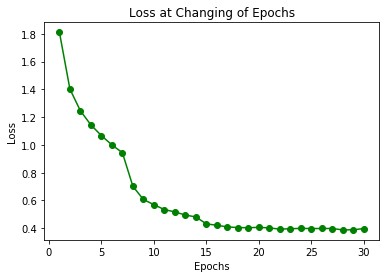

<Figure size 432x288 with 0 Axes>

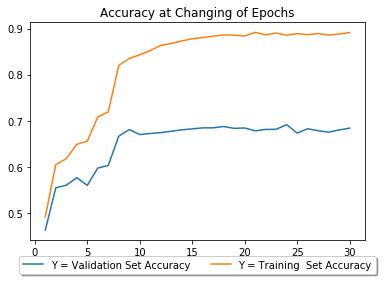

In [12]:

#Plot loss
pl.plot(epochs, loss_val, marker = "o", color ='green')
pl.title("Loss at Changing of Epochs")
pl.xlabel("Epochs")
pl.ylabel("Loss")
pl.show()

pl.cla()
pl.clf()

#Plot Accuracy
fig = pl.figure()
ax = pl.subplot(111)
ax.plot(epochs, accuracyVal, label='Y = Validation Set Accuracy')
ax.plot(epochs, accuracyTrain, label='Y = Training  Set Accuracy')
pl.title("Accuracy at Changing of Epochs")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
pl.show()



**Test**

In [13]:

net.load_state_dict(torch.load('./bestModel.pth'))

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0

classNumT = numpy.zeros(14)
classDenT = numpy.zeros(14)
classTopKNumT = numpy.zeros(14)
cnfMatrixT = numpy.zeros((14, 14))

topT = 0

for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)#, ifClas =True)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)
  predTop = outputs.topk(3,1,largest=True,sorted=True)#torch.max(outputs.data, 1)



  #print("\npippo",predTop.indices)

  for l, m in zip(preds, labels.data):
    if l == m: 
      classNumT[m] += 1

    classDenT[m] += 1

  
  for a, b in zip(predTop.indices, labels.data):

    for p in a:
      if p == b: 
        classTopKNumT[b] += 1  
        topT += 1

  #confusion matrix
  cnfMatrixT[m][l] += 1 

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))
topA = topT / float(len(test_dataset))
for i in range(14):
    fraz = classNumT[i] / classDenT[i]
    frazTop = classTopKNumT[i] / classDenT[i]
    classe = train_dataset.dataset.classes[i]
    print("\nAccuracy ",classe," = ", fraz)
    print("\nTop 3 Accuracy ",classe," = ", frazTop)

for y in range(14):
      print(train_dataset.dataset.classes[y]," ")
      for z in range(14):
        print(cnfMatrixT[y][z]," ")

      print("\n")      

print('Test Accuracy: {}'.format(accuracy))
print('Top 3 Accuracy Test Accuracy: ', topA)


100%|██████████| 70/70 [05:18<00:00,  4.54s/it]



Accuracy  Abstract_Expressionism2000  =  0.82

Top 3 Accuracy  Abstract_Expressionism2000  =  0.95

Accuracy  Art_Nouveau_Modern2000  =  0.74

Top 3 Accuracy  Art_Nouveau_Modern2000  =  0.9

Accuracy  Baroque2200  =  0.815

Top 3 Accuracy  Baroque2200  =  0.965

Accuracy  Cubism2200  =  0.825

Top 3 Accuracy  Cubism2200  =  0.97

Accuracy  Expressionism2200  =  0.645

Top 3 Accuracy  Expressionism2200  =  0.905

Accuracy  Impressionism2200  =  0.72

Top 3 Accuracy  Impressionism2200  =  0.915

Accuracy  Naive_Art_Primitivism2200  =  0.735

Top 3 Accuracy  Naive_Art_Primitivism2200  =  0.915

Accuracy  Northern_Renaissance2200  =  0.895

Top 3 Accuracy  Northern_Renaissance2200  =  0.97

Accuracy  Post_Impressionism2200  =  0.625

Top 3 Accuracy  Post_Impressionism2200  =  0.875

Accuracy  Realism2200  =  0.555

Top 3 Accuracy  Realism2200  =  0.88

Accuracy  Rococo2200  =  0.755

Top 3 Accuracy  Rococo2200  =  0.96

Accuracy  Romanticism2200  =  0.67

Top 3 Accuracy  Romanticism2200  